# Decision Trees

There have been many studies and publications using decision trees for time series or stock signal predicition. Some of these papers have yielded very impressive results especially for signal predictions. The idea here is that a decision tree emulates the natural thought process of a human trader, i.e. making trades based on whether certain conditions have been met for that ticker.

This part will explore the intuition behind decision trees before training our own classification trees for the AAPL data set.



### Contents:
0. Background 
1. Data Exploration
2. Feature Engineering
3. Training Classification Trees
4. Training Regression Tree

## Background


### Classification Trees

The decision tree algorithm aims to recursively split the data points in the training set until the data points are completely separated or well separated. At each iteration, the tree splits the datasets by the feature(s) that give the maximum reduction in heterogeneity, which is calculated by a heterogeneity index.

Below is a binary decision tree that has been split for a few iterations.

![image.png](https://elf11.github.io/images/decisionTree.png)

For the problem of signal prediction, the target is a binary signal (signal = up or down). Therefore, we will be building a binary decision tree, using the the GINI Index as the Heterogeneity index. The GINI is given by:

![image.png](https://miro.medium.com/max/664/1*otdoiyIwxJI-UV0ukkyutw.png)

The GINI index measures how heterogenous a single node is (0 being completely homogenous and 1 being heterogenous). For each possible split, we will calculate the *weighted sum* of the GINI indices of the child nodes, and choose the split that results in the maximum information gain. i.e. reduction in the weighted sum of the GINI Index.

### Ensembling
Ensembling means we train multiple trees and aggregate the results from all our trees to make a decision.

#### Random Forest

Random Forest is an ensemble method for the decision tree algorithm. It works by randomly choosing different features and data points to train multiple trees (that is, to form a forest) - and the resulting prediction is decided by the votes from all the trees. 

Decision Trees are prone to overfitting on the training data, which reduces the performance on the test set. Random Forest mitigates this by training multiple trees. Random Forest is a form of bagging ensemble where the trees are trained concurrently. 

#### Gradient Boosting Trees (xgBoost)
xgBoost is short for "Extreme Gradient Boosting". It is a boosting ensemble method for decision trees. This means that the trees are trained consecutively, where each new tree added is trained to correct the error from the previous tree.

xgBoost uses the gradient descent algorithm at each iteration to maximise the reduction in the error term. 

### Regression Trees
Regression trees operate on a similar principle. Instead of splitting the datapoints into different groups based on their class, we split the data points into different groups by minimising the Sum of Squared errors in each child node at each split.

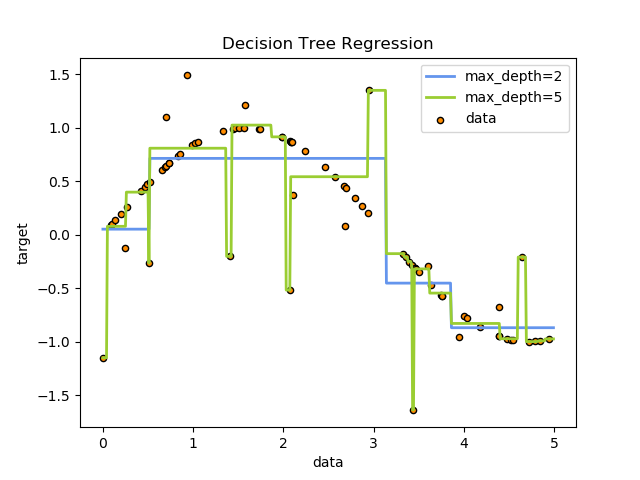

## Packages

In [1]:
from sklearn.ensemble import *
from sklearn.metrics import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ta import *

## Data Exploration

In [3]:
# This is from Samuel's part
df = pd.read_csv('AAPL.csv') #Read the data in
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d') #Set the date column to datetime
#df.set_index('Date', inplace=True) #Set the index to the date column
df = df.rename(columns = {'Adj Close':'Adj_Close'})
df = df.rename(columns = {'Date':'Timestamp'})
df.head(5) #Observe a few rows of data

,Timestamp,Open,High,Low,Close,Adj_Close,Volume
0,2000-08-31,4.212054,4.392857,4.209821,4.352679,3.798641,104899200
1,2000-09-01,4.379464,4.544643,4.366071,4.531250,3.954481,64218000
2,2000-09-05,4.475446,4.580357,4.446429,4.459821,3.892146,74660600
3,2000-09-06,4.383929,4.455357,4.125000,4.174107,3.642799,88851000
4,2000-09-07,4.223214,4.468750,4.160714,4.428571,3.864874,54366200


In [4]:
#Target - next day price
target =  list(df["Adj_Close"])[3:] + [0,0,0]
#df["Target"] = target
df["Binary_Target"] = target > df["Adj_Close"]
df = df.drop("Close", axis = 1)
df["Close"] = df["Adj_Close"]
df.head()

,Timestamp,Open,High,Low,Adj_Close,Volume,Binary_Target,Close
0,2000-08-31,4.212054,4.392857,4.209821,3.798641,104899200,False,3.798641
1,2000-09-01,4.379464,4.544643,4.366071,3.954481,64218000,False,3.954481
2,2000-09-05,4.475446,4.580357,4.446429,3.892146,74660600,False,3.892146
3,2000-09-06,4.383929,4.455357,4.125000,3.642799,88851000,False,3.642799
4,2000-09-07,4.223214,4.468750,4.160714,3.864874,54366200,False,3.864874


## Feature Engineering

In this section we will be creating technical indicators that are commonly used for stock technical analysis. We use the package "ta" to create the technical indicators. To remain consistent with the other models, we will only use features engineered from the time series data. As we will observe later, this is a major limitation to our decision treees model.

### Indicators:

#### Volume
1. Accumulation/Distribution Index (ADI)
2. On-Balance Volume (OBV)
3. Chaikin Money Flow (CMF)
4. Force Index (FI)
5. Ease of Movement (EoM, EMV)
6. Volume-price Trend (VPT)
7. Negative Volume Index (NVI)

#### Volatility
1. Average True Range (ATR)
2. Bollinger Bands (BB)
3. Keltner Channel (KC)
4. Donchian Channel (DC)

#### Trend
1. Moving Average Convergence Divergence (MACD)
2. Average Directional Movement Index (ADX)
3. Vortex Indicator (VI)
4. Trix (TRIX)
5. Mass Index (MI)
6. Commodity Channel Index (CCI)
7. Detrended Price Oscillator (DPO)
8. KST Oscillator (KST)
9. Ichimoku Kinkō Hyō (Ichimoku)

#### Momentum
1. Money Flow Index (MFI)
2. Relative Strength Index (RSI)
3. True strength index (TSI)
4. Ultimate Oscillator (UO)
5. Stochastic Oscillator (SR)
6. Williams %R (WR)
7. Awesome Oscillator (AO)
8. Kaufman's Adaptive Moving Average (KAMA)

#### Others
1. Daily Return (DR)
2. Daily Log Return (DLR)
3. Cumulative Return (CR)
4. 3 day moving Average

For a start, we simply add every single indicator into our dataset. The decision tree algorithm includes embedded feature selection, which means the model will conduct feature selection automatically during the training phase.


In [5]:
def sma(n, ts):
    return ts.rolling(window=n).mean()

In [6]:
df= add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)
df["3sma"] = sma(3,df["Close"])
df["50sma"] = sma(50,df["Close"])
df = df.dropna()
df.head(15)

C:\Users\reonh\Anaconda3\lib\site-packages\ta\trend.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
C:\Users\reonh\Anaconda3\lib\site-packages\ta\trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
C:\Users\reonh\Anaconda3\lib\site-packages\ta\trend.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
C:\Users\reonh\Anaconda3\lib\site-packages\ta\trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
C:\Users\reonh\Anaconda3\lib\site-packages\ta\trend.py:176: RuntimeWarning: invalid value encountered in subtract
  dx = 100 * np.abs((dip - din) / (dip + din))


,Timestamp,Open,High,Low,Adj_Close,Volume,Binary_Target,Close,volume_adi,volume_obv,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,3sma,50sma
49,2000-11-09,1.419643,1.464286,1.361607,1.258421,119208600,True,1.258421,-7.635159e+08,-3.225761e+09,...,1.145117,2.143528,7.432730,-97.856472,-0.253545,0.623046,0.621114,-66.871810,1.279200,2.215114
50,2000-11-10,1.382813,1.419643,1.361607,1.188292,105562800,True,1.188292,-1.094858e+09,-3.331324e+09,...,-4.343012,-15.707497,-4.467953,-115.707497,-0.224317,-5.572777,-5.734078,-68.717970,1.232447,2.162907
51,2000-11-13,1.339286,1.428571,1.303571,1.207773,107954000,False,1.207773,-1.009477e+09,-3.223370e+09,...,-7.167479,-10.748695,-8.104221,-110.748695,-0.190520,1.639412,1.626119,-68.205129,1.218162,2.107973
52,2000-11-14,1.424107,1.464286,1.397321,1.262317,102250400,False,1.262317,-7.879543e+08,-3.121119e+09,...,-3.965633,3.135238,-7.773651,-96.864762,-0.144814,4.516080,4.417075,-66.769247,1.219461,2.055376
53,2000-11-15,1.430804,1.441964,1.375000,1.238941,70589400,False,1.238941,-8.719716e+08,-3.191709e+09,...,-3.335379,-10.338158,-5.983872,-110.338158,-0.092109,-1.851833,-1.869194,-67.384625,1.236344,2.007299
54,2000-11-16,1.392857,1.415179,1.348214,1.184396,59843000,False,1.184396,-7.100733e+08,-3.251552e+09,...,-5.892147,-35.125234,-14.109385,-135.125234,-0.081880,-4.402550,-4.502404,-68.820533,1.228551,1.953689
55,2000-11-17,1.370536,1.375000,1.303571,1.153228,111545000,False,1.153228,-9.337360e+08,-3.363097e+09,...,-4.707452,-44.311584,-29.924992,-144.311584,-0.078755,-2.631552,-2.666797,-69.641037,1.192188,1.903352
56,2000-11-20,1.328125,1.392857,1.303571,1.180500,102016600,True,1.180500,-9.643565e+08,-3.261080e+09,...,-3.529126,-36.273527,-38.570115,-136.273527,-0.072413,2.364840,2.337311,-68.923096,1.172708,1.854106
57,2000-11-21,1.370536,1.392857,1.339286,1.172708,75488000,False,1.172708,-9.281991e+08,-3.336568e+09,...,-1.727826,-38.570115,-39.718409,-138.570115,-0.077613,-0.660059,-0.662247,-69.128222,1.168812,1.805562
58,2000-11-22,1.343750,1.366071,1.312500,1.153228,70133000,False,1.153228,-1.032103e+09,-3.406701e+09,...,-4.938473,-44.311584,-39.718409,-144.311584,-0.081999,-1.661113,-1.675064,-69.641037,1.168812,1.756316


In [7]:
#Shape of the dataframe
print("There are " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " features")

There are 4730 rows and 68 features


## Classification Tree Training

In [8]:
np.random.seed(1997) #make results reproducible

In [9]:
# Split into independent and dependent variables
df = df[df["Timestamp"] > '2015-09-01']
X = df.copy().drop('Binary_Target', axis =1)
y = df[['Timestamp','Binary_Target']]

# Get Training set
X_train = X[X["Timestamp"] <= '2018-08-31']
y_train = y[y["Timestamp"] <= '2018-08-31']

X_test = X[X["Timestamp"] > '2018-08-31']
y_test = y[y["Timestamp"] > '2018-08-31']

In [10]:
#Test set
X_test.set_index('Timestamp', inplace=True) #Set the index to the date column
y_test.set_index('Timestamp', inplace=True) #Set the index to the date column

In [11]:
X_train.set_index('Timestamp', inplace=True) #Set the index to the date column
y_train.set_index('Timestamp', inplace=True) #Set the index to the date column
y_train = np.ravel(y_train)

In [12]:
def get_roc(model, y_test, X_test, name):
    fpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[0]
    tpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[1]

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + name)
    plt.plot(fpr,tpr,label='ROC curve (AUC = %0.2f)' % (auc(fpr, tpr)))
    plt.legend(loc="lower right")
    plt.show()

## Iteration 0 (All Features, Single Decision Tree)
For the zeroth iteration, no featue selection will be conducted. Instead, the decision tree algorithm automatically does feature selection for us by picking features that best split the data. In this case, we use the GINI Index to calculate our information gain.

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
clf0 = DecisionTreeClassifier(min_samples_split = 5)
clf0.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [15]:
print(classification_report(y_test["Binary_Target"], clf0.predict(X_test)))

              precision    recall  f1-score   support

       False       0.51      0.53      0.52       113
        True       0.60      0.58      0.59       137

    accuracy                           0.56       250
   macro avg       0.55      0.55      0.55       250
weighted avg       0.56      0.56      0.56       250



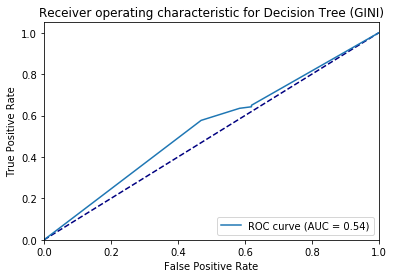

In [16]:
get_roc(clf0, y_test, X_test, "Decision Tree (GINI)")

The results show that the lone decision tree performs slightly better than random chance (the baseline ROC). 

Of interest is the recall value for "True" and "False" signals. For example, A 60% recall means that our model is able to detect ~60% of all trading days that will result in losses. The recalls here are both greater than 50% which is a good result.

Although this is not a remarkable result it is still promising and we will explore further with ensembles.

## Iteration 1 (All Features, Random Forest)
For this first iteration, no featue selection will be conducted too. Instead, the Random Forest algorithm randomly selects features for each tree, which does the feature selection by picking features that best split the data. Again, we use the GINI Index to calculate our information gain.

In [17]:
clf = RandomForestClassifier(n_estimators=100, bootstrap = "False" ,min_samples_split = 5)

In [18]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap='False', class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
predicted = clf.predict(X_test)

In [20]:
pd.crosstab(y_test["Binary_Target"],predicted, rownames=['Actual'], colnames=['Predicted'])

Predicted,False,True
Actual,,
False,10,103
True,19,118


In [21]:
print(classification_report(y_test["Binary_Target"], predicted))

              precision    recall  f1-score   support

       False       0.34      0.09      0.14       113
        True       0.53      0.86      0.66       137

    accuracy                           0.51       250
   macro avg       0.44      0.47      0.40       250
weighted avg       0.45      0.51      0.42       250



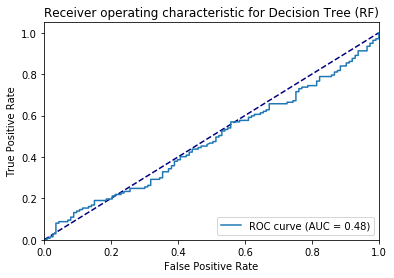

In [22]:
get_roc(clf, y_test, X_test, "Decision Tree (RF)")

Our model accuracy is pretty bad -  note that since this is a binary classification problem, the nearer the accuracy is to 50%, the worse the model is. What is more worrying is the recall for True has increased significantly whereas that for False is almost zero. The random forest model performs worse than our original since it is unable to detect loss-making days, and seems to predict that prices will go up for all days.

## Iteration 2 (xgBoost, all 31 features)

In [23]:
xgb_clf = GradientBoostingClassifier(n_estimators=300, learning_rate = 0.1, min_samples_split = 5).fit(X_train, y_train)

In [24]:
predicted_xgb = xgb_clf.predict(X_test)

In [25]:
pd.crosstab(y_test["Binary_Target"],predicted_xgb, rownames=['Actual'], colnames=['Predicted'])

Predicted,False,True
Actual,,
False,25,88
True,26,111


In [26]:
print(classification_report(y_test["Binary_Target"], predicted_xgb))

              precision    recall  f1-score   support

       False       0.49      0.22      0.30       113
        True       0.56      0.81      0.66       137

    accuracy                           0.54       250
   macro avg       0.52      0.52      0.48       250
weighted avg       0.53      0.54      0.50       250



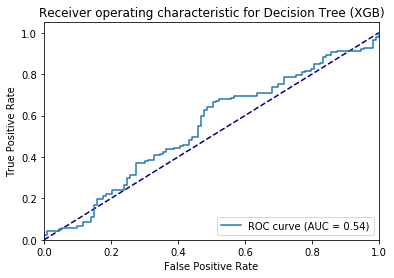

In [27]:
get_roc(xgb_clf, y_test, X_test, "Decision Tree (XGB)")

The xgBoost model performs better than random forest in terms of accuracy. And has a larger AUC which implies a better fit for the data. The recall on "False" is again very low. This is worrying since our model cannot detect loss making days and this model would also be dangerous to deploy. 

## Iteration 3 (Random Forest, with feature selection for top 17 features)


In this part, we will attempt to do some preliminary feature selection to reduce noise in the training phase. We select an arbitrary number of features to feed into the mode. In this case, we chose k=17 features (a quarter the number of original features (66))

In [28]:
from sklearn.feature_selection import *

In [29]:
k = 17
X_test_kbest = pd.DataFrame(SelectKBest(f_classif, k=k).fit(X_train, y_train).transform(X_test))
X_train_kbest = pd.DataFrame(SelectKBest(f_classif, k=k).fit(X_train, y_train).transform(X_train))

C:\Users\reonh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [22 33 34 35] are constant.
  UserWarning)
C:\Users\reonh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\reonh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [22 33 34 35] are constant.
  UserWarning)
C:\Users\reonh\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [30]:
X_test_kbest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-7.018517e+07,588591.060150,5.942630,0.0,7.104949,6.364544,0.740405,0.313324,0.421885,0.468248,164.637414,116.707855,115.295443,100.0,96.0,39.646182,17.172351
1,7.489134e+06,-129650.983236,5.860978,0.0,7.106146,6.512864,0.593282,0.333101,0.403485,0.476275,136.004583,116.694393,115.634555,96.0,92.0,40.458400,17.629235
2,-3.573869e+07,-787298.698392,5.874480,0.0,6.729959,6.556283,0.173676,0.427820,0.276444,0.477854,83.491427,115.690799,115.882929,92.0,76.0,40.319364,17.227617
3,-2.351251e+07,-873330.138727,5.860524,0.0,6.217135,6.488454,-0.271319,0.513419,0.180314,0.472384,57.599319,113.696129,115.869700,88.0,76.0,39.786549,15.836089
4,-2.454962e+07,-833866.289618,5.826201,0.0,5.511194,6.293002,-0.781808,0.584924,0.045042,0.458715,5.925027,109.694724,115.361657,84.0,76.0,38.645028,13.345796


In [31]:
X_train_kbest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-2.218388e+06,-7.804098e+05,9.780443,0.0,-2.533268,-2.919766,0.386498,0.472254,0.063654,-0.396304,-27.695586,-90.582567,-89.457481,4.0,-68.0,-17.692531,-5.571325
1,-5.839715e+07,1.720834e+06,9.648624,0.0,-2.421515,-2.820116,0.398601,0.474710,0.049778,-0.386181,-26.959246,-89.001206,-90.442538,4.0,-64.0,-17.357702,-5.099001
2,3.407425e+07,-1.431804e+06,9.491118,0.0,-2.388258,-2.733744,0.345486,0.507114,0.099759,-0.376719,-54.725050,-84.774379,-90.039443,24.0,-40.0,-17.217389,-5.030501
3,2.914475e+06,1.027517e+06,9.568907,0.0,-2.108658,-2.608727,0.500069,0.487091,0.071795,-0.362330,-0.361245,-78.388550,-88.584642,20.0,-40.0,-16.521244,-4.801972
4,2.875702e+07,-1.091654e+05,9.542770,0.0,-2.026379,-2.492257,0.465878,0.482388,0.048453,-0.348131,-4.889481,-73.317385,-86.471932,16.0,-40.0,-16.204549,-3.998442


In [32]:
clf3 = RandomForestClassifier(n_estimators=200, random_state=0)
clf3.fit(X_train_kbest, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [33]:
predicted3 = clf3.predict(X_test_kbest)

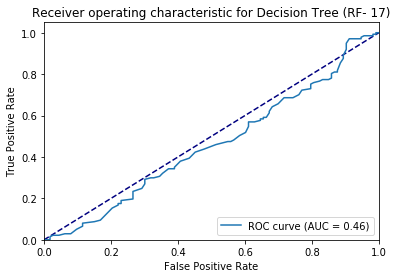

In [34]:
get_roc(clf3, y_test, X_test_kbest, "Decision Tree (RF- 17)")

In [35]:
print(classification_report(y_test["Binary_Target"], predicted3))

              precision    recall  f1-score   support

       False       0.42      0.29      0.35       113
        True       0.53      0.67      0.60       137

    accuracy                           0.50       250
   macro avg       0.48      0.48      0.47       250
weighted avg       0.48      0.50      0.48       250



## Iteration 4 (xgboost, feature selection)

In [36]:
xgb_clf2 = GradientBoostingClassifier(n_estimators=300, learning_rate = 0.1, min_samples_split = 5).fit(X_train_kbest , y_train)

In [37]:
predicted_xgb2 = xgb_clf2.predict(X_test_kbest)

In [38]:
print(classification_report(y_test["Binary_Target"], predicted_xgb2))

              precision    recall  f1-score   support

       False       0.59      0.30      0.40       113
        True       0.59      0.82      0.69       137

    accuracy                           0.59       250
   macro avg       0.59      0.56      0.54       250
weighted avg       0.59      0.59      0.56       250



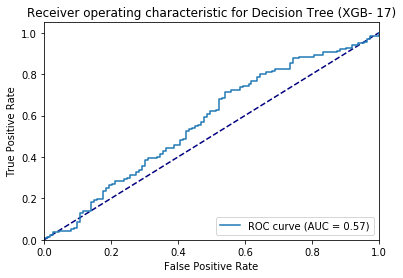

In [39]:
get_roc(xgb_clf2, y_test, X_test_kbest, "Decision Tree (XGB- 17)")

We can observe that XGBoost benefited from the feature selection, since it is prone to overfitting. Random Forest however, did not improve with feature selection since the algorithm includes randomly selecting features. The less features to select, the less trees in the forest and the worse the model performs.


## Conclusion - Signal Processing
In conclusion, decision trees show some promise in predicitng stock prices, with accuracies that are slightly better than random chance. 

As mentioned earlier, the limitation of our model includes the fact that all our features are combinations of the OHLC Data. A better decision tree model will definitely need to account for external indicators like news headlines, market performance of other stocks, fundamental ratios of the underlying company (AAPL) and so on. In reality, traders rarely make trades based on TA of a single stock in isolation so our Decision tree has not been able to perform as well in that regard. 


## Regresson Tree Training
We will now train a regression tree for price prediction. 

In [40]:
target = pd.DataFrame(list(X_train["Adj_Close"])[3:] + 3*[None]).dropna()
target_test = pd.DataFrame(list(X_test["Adj_Close"])[3:] + 3*[None]).dropna()
#df = df.drop("Binary_Target",axis =1)

In [41]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

### Iteration 0: Lone Regression Tree

In [42]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train[3:],target)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

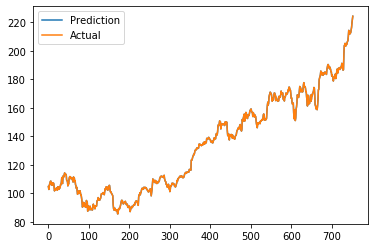

In [43]:
plt.figure()
plt.plot(regressor.predict(X_train[3:]))
plt.plot(target)
plt.legend(['Prediction', 'Actual'], loc='best')

The two lines are almost identical. Training accuracy is pretty good (as to be expected from a decision tree). Now for predictions on the test set.

In [44]:
y_pred = regressor.predict(X_test[3:])
r2_score(target_test, y_pred)

0.8944257541923192

The R2 is 78.9%, which means our model can account for 78.9% of the variation in AAPL stock prices. This is a good sign.

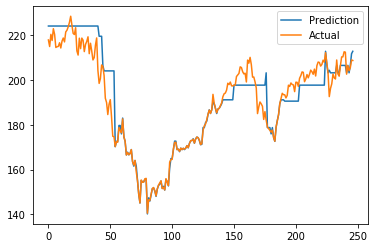

In [45]:
plt.figure()
plt.plot(y_pred)
plt.plot(target_test)
plt.legend(['Prediction', 'Actual'], loc='best')

In [46]:
from sklearn.metrics import mean_squared_error

In [47]:
mean_squared_error(target_test, y_pred)

45.737415559504754

### Gradient Boosted Regressor 
Since our RF performed very badly in the signal predictions case, we will be skipping to gradient boosted regression. Gradient Boosted trees performed the best for signal prediction with k = 17. We will try these parameters for our boosted regression tree first.

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

In [49]:
gb_rgr = GradientBoostingRegressor()

In [50]:
gb_rgr.fit(X_train_kbest[3:], np.ravel(target))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

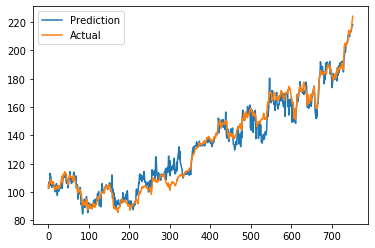

In [51]:
plt.figure()
plt.plot(gb_rgr.predict(X_train_kbest[3:]))
plt.plot(target)
plt.legend(['Prediction', 'Actual'], loc='best')

The prediction on training set is not as accurate as a lone decision tree. This can be a good sign that the model has not been overfitted - we will see.

In [52]:
xgb_pred = gb_rgr.predict(X_test_kbest[3:])
r2_score(target_test, xgb_pred)

-0.566585284802614

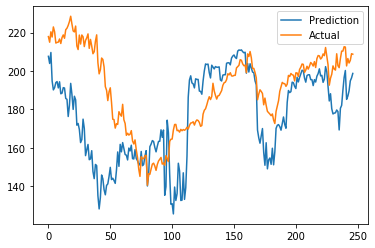

In [53]:
plt.figure()
plt.plot(xgb_pred)
plt.plot(target_test)
plt.legend(['Prediction', 'Actual'], loc='best')

In [54]:
mean_squared_error(target_test, xgb_pred)

678.6841017168734

The performance is abysmal for Gradient Boosted Trees with 17 features. Trying again with all features:

In [55]:
gb_rgr2 = GradientBoostingRegressor()
gb_rgr2.fit(X_train[3:], np.ravel(target))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

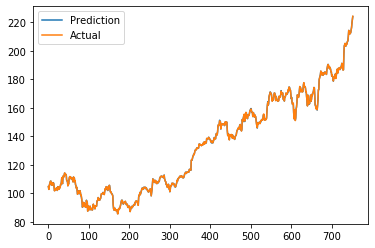

In [56]:
plt.figure()
plt.plot(gb_rgr2.predict(X_train[3:]))
plt.plot(target)
plt.legend(['Prediction', 'Actual'], loc='best')

In [58]:
xgb_pred2 = gb_rgr2.predict(X_test[3:])
r2_score(target_test, xgb_pred2)

0.9635292264400017

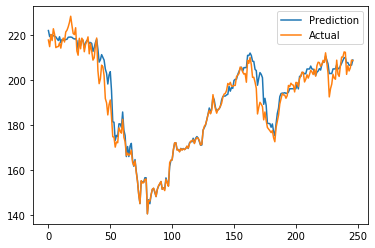

In [59]:
plt.figure()
plt.plot(xgb_pred2)
plt.plot(target_test)
plt.legend(['Prediction', 'Actual'], loc='best')

In [60]:
mean_squared_error(target_test, xgb_pred2)

15.800055338580325

Impressive results! Our gradient boosted regressor with all features has managed to perform very very well with an R^2 of 0.96773!

## Conclusion - Regression
In conclusion, regression trees perform very well for price prediction. We are however limited by the fact that the model we trained only forecasts 3 days into the future. Application for regression trees is also not as clear as for signal prediction (buy or sell).

The results for decision trees are below for comparison with Prophet and LSTM.

In [61]:
model = ["Lone Tree", "RF", "XGB", "RF-17", "XGB-17"]
acc = [0.56, 0.51, 0.54, 0.50, 0.59]
ROC = [0.54, 0.48, 0.54, 0.46, 0.57]
rsq = [0.789, None, 0.964, None,0.578]
mse = [91.4, None,15.8, None, 683]

res = pd.DataFrame([acc, ROC, rsq, mse])
res.columns = model
res.index = ["Acc", "ROC", "Rsquare", "MSE"]
res

,Lone Tree,RF,XGB,RF-17,XGB-17
Acc,0.560,0.51,0.540,0.50,0.590
ROC,0.540,0.48,0.540,0.46,0.570
Rsquare,0.789,NaN,0.964,NaN,0.578
MSE,91.400,NaN,15.800,NaN,683.000
